## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

ModuleNotFoundError: No module named 'torch'

In [ ]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#My, no denoiser

#denoiser = waveglow

/home/valery/.local/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/valery/.local/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
waveglow/glow.py:162: RuntimeWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  torch.IntTensor([self.n_channels]))
waveglow/glow.py:162: RuntimeWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid inst

#### Prepare text input

In [120]:
text = 'Jack, half because the word had got around their parents and they had been instructed to keep away.'
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

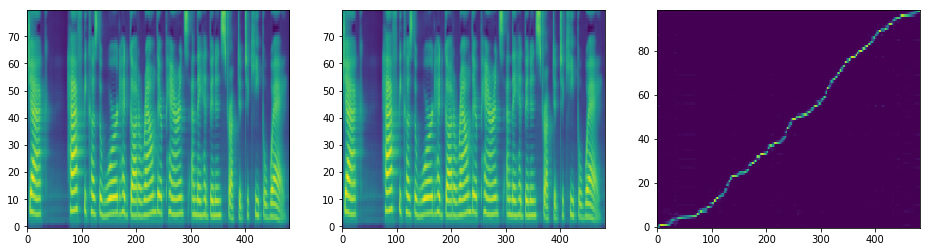

In [121]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [122]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [99]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
res = ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

In [100]:
res

In [129]:
hparams.sampling_rate

22050

In [225]:
import soundfile as sf
""
sf.write( 'test.wav', data1.ravel().astype("float64"), samplerate=hparams.sampling_rate)

In [ ]:
sf.write('new_file.flac', data, samplerate)

In [175]:
data, samplerate = sf.read('demo.wav')d

In [221]:
type(data[0])

numpy.float64

In [195]:
data1 = audio.cpu().numpy()

In [206]:
data1.ravel().shape

(123392,)